##Imports

In [ ]:
!pip install cmapPy

In [2]:
from cmapPy.pandasGEXpress import parse

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

#Pre-processing
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import quantile_transform

from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV


## 0. Read the files


#### Reading the GCT-structured files - which include observations and features (genes)

In [3]:
data = parse.parse("adipose_subcutaneous.gct")

In [4]:
data2 = parse.parse("brain_cortex.gct")

In [5]:
# Extract the data matrix
adipose = data.data_df
brain_cortex = data2.data_df

In [6]:
# Display the structure of the dataframe
print("Adipose subcutaneous data:\n")
print(adipose.info())
print("\nBrain cortex data:\n")
print(brain_cortex.info())

Adipose subcutaneous data:

<class 'pandas.core.frame.DataFrame'>
Index: 56200 entries, ENSG00000223972.5 to ENSG00000210196.2
Columns: 663 entries, GTEX-1117F-0226-SM-5GZZ7 to GTEX-ZZPU-2726-SM-5NQ8O
dtypes: float32(663)
memory usage: 144.6+ MB
None

Brain cortex data:

<class 'pandas.core.frame.DataFrame'>
Index: 56200 entries, ENSG00000223972.5 to ENSG00000210196.2
Columns: 255 entries, GTEX-1117F-3226-SM-5N9CT to GTEX-ZZPT-3026-SM-5GZXH
dtypes: float32(255)
memory usage: 57.1+ MB
None


Glimpse of the data

In [7]:
# Show the first few rows and a subset of columns
num_rows = 4
num_cols = 6

adipose_subset = adipose.iloc[:num_rows, :num_cols]
brain_subset = brain_cortex.iloc[:num_rows, :num_cols]

In [ ]:
# Display the Adipose subset
print("\nAdipose Data Subset:\n")
print(adipose_subset)


Adipose Data Subset:

cid                GTEX-1117F-0226-SM-5GZZ7  GTEX-111CU-1826-SM-5GZYN  \
rid                                                                     
ENSG00000223972.5                    0.0000                     0.000   
ENSG00000227232.5                    8.7640                     3.082   
ENSG00000278267.1                    0.0000                     0.000   
ENSG00000243485.5                    0.0719                     0.000   

cid                GTEX-111FC-0226-SM-5N9B8  GTEX-111VG-2326-SM-5N9BK  \
rid                                                                     
ENSG00000223972.5                    0.0000                    0.0000   
ENSG00000227232.5                    4.2000                    3.2010   
ENSG00000278267.1                    0.0000                    0.5898   
ENSG00000243485.5                    0.0418                    0.0000   

cid                GTEX-111YS-2426-SM-5GZZQ  GTEX-1122O-2026-SM-9YFMG  
rid                        

In [ ]:
print("Initial shape of adipose dataset: ", adipose.shape)

Initial shape of adipose dataset:  (56200, 663)


In [ ]:
# Display the Brian subset
print("\nBrain Data Subset:\n")
print(brain_subset)


Brain Data Subset:

cid                GTEX-1117F-3226-SM-5N9CT  GTEX-111FC-3126-SM-5GZZ2  \
rid                                                                     
ENSG00000223972.5                    0.0178                    0.0000   
ENSG00000227232.5                    6.8920                    4.2250   
ENSG00000278267.1                    0.0000                    0.4912   
ENSG00000243485.5                    0.0000                    0.0771   

cid                GTEX-1128S-2726-SM-5H12C  GTEX-117XS-3026-SM-5N9CA  \
rid                                                                     
ENSG00000223972.5                    0.0171                    0.0000   
ENSG00000227232.5                    2.3590                    3.6930   
ENSG00000278267.1                    0.0000                    0.0000   
ENSG00000243485.5                    0.0341                    0.0308   

cid                GTEX-1192X-3126-SM-5N9BY  GTEX-11DXW-1126-SM-5H12Q  
rid                          

In [ ]:
print("Initial shape of Brain dataset: ", brain_cortex.shape)

Initial shape of Brain dataset:  (56200, 255)


#### Reading the Sample attributes file- which includes the target variable

Our target varibale: SMTSISCH

In [8]:
file_path = 'GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt'
help_df = pd.read_csv(file_path, delimiter='\t', encoding='utf-8', low_memory=False)

In [ ]:
# Display the first 4 rows and 11 columns
print(help_df.head(4).iloc[:, :11])

                          SAMPID  SMATSSCR SMCENTER SMPTHNTS  SMRIN   SMTS  \
0       GTEX-1117F-0003-SM-58Q7G       NaN       B1      NaN    NaN  Blood   
1       GTEX-1117F-0003-SM-5DWSB       NaN       B1      NaN    NaN  Blood   
2       GTEX-1117F-0003-SM-6WBT7       NaN       B1      NaN    NaN  Blood   
3  GTEX-1117F-0011-R10a-SM-AHZ7F       NaN   B1, A1      NaN    NaN  Brain   

                          SMTSD  SMUBRID  SMTSISCH  SMTSPAX  SMNABTCH  
0                   Whole Blood  0013756    1188.0      NaN  BP-38516  
1                   Whole Blood  0013756    1188.0      NaN  BP-38516  
2                   Whole Blood  0013756    1188.0      NaN  BP-38516  
3  Brain - Frontal Cortex (BA9)  0009834    1193.0      NaN       NaN  


In [11]:
#Extract the Total Ischemic Time variable - Target

total_ischemic_time = help_df[['SAMPID', 'SMTSISCH']]
print(total_ischemic_time)

                              SAMPID  SMTSISCH
0           GTEX-1117F-0003-SM-58Q7G    1188.0
1           GTEX-1117F-0003-SM-5DWSB    1188.0
2           GTEX-1117F-0003-SM-6WBT7    1188.0
3      GTEX-1117F-0011-R10a-SM-AHZ7F    1193.0
4      GTEX-1117F-0011-R10b-SM-CYKQ8    1193.0
...                              ...       ...
22946                 K-562-SM-E9EZC       NaN
22947                 K-562-SM-E9EZI       NaN
22948                 K-562-SM-E9EZO       NaN
22949                 K-562-SM-E9EZT       NaN
22950                 K-562-SM-E9EZZ       NaN

[22951 rows x 2 columns]


#### Merging the datasets - features (genes) and samples datasets, with the target variable

In [9]:
# Transpose the datasets so we get genes as columns and samples as rows
brain_cortex_t = brain_cortex.T
adipose_subcutaneous_t = adipose.T

Now we have the datasets transposed, the observations in rows and the features in columns

In [ ]:
print(adipose_subcutaneous_t.head(4).iloc[:, :4])

rid                       ENSG00000223972.5  ENSG00000227232.5  \
cid                                                              
GTEX-1117F-0226-SM-5GZZ7                0.0              8.764   
GTEX-111CU-1826-SM-5GZYN                0.0              3.082   
GTEX-111FC-0226-SM-5N9B8                0.0              4.200   
GTEX-111VG-2326-SM-5N9BK                0.0              3.201   

rid                       ENSG00000278267.1  ENSG00000243485.5  
cid                                                             
GTEX-1117F-0226-SM-5GZZ7             0.0000             0.0719  
GTEX-111CU-1826-SM-5GZYN             0.0000             0.0000  
GTEX-111FC-0226-SM-5N9B8             0.0000             0.0418  
GTEX-111VG-2326-SM-5N9BK             0.5898             0.0000  


In [ ]:
print(brain_cortex_t.head(4).iloc[:, :4])

rid                       ENSG00000223972.5  ENSG00000227232.5  \
cid                                                              
GTEX-1117F-3226-SM-5N9CT             0.0178              6.892   
GTEX-111FC-3126-SM-5GZZ2             0.0000              4.225   
GTEX-1128S-2726-SM-5H12C             0.0171              2.359   
GTEX-117XS-3026-SM-5N9CA             0.0000              3.693   

rid                       ENSG00000278267.1  ENSG00000243485.5  
cid                                                             
GTEX-1117F-3226-SM-5N9CT             0.0000             0.0000  
GTEX-111FC-3126-SM-5GZZ2             0.4912             0.0771  
GTEX-1128S-2726-SM-5H12C             0.0000             0.0341  
GTEX-117XS-3026-SM-5N9CA             0.0000             0.0308  


Merge datasets with target variable so we get the ischemic time value for each observation

In [12]:
merged_brain = pd.merge(brain_cortex_t, total_ischemic_time, left_index=True, right_on='SAMPID')
merged_adipose = pd.merge(adipose_subcutaneous_t, total_ischemic_time, left_index=True, right_on='SAMPID')

In [ ]:
print("Brain dataset columns (after merging):\n\n", merged_brain.columns)
print("\nAdipose dataset columns (after merging):\n\n",merged_adipose.columns)

Brain dataset columns (after merging):

 Index(['ENSG00000223972.5', 'ENSG00000227232.5', 'ENSG00000278267.1',
       'ENSG00000243485.5', 'ENSG00000237613.2', 'ENSG00000268020.3',
       'ENSG00000240361.1', 'ENSG00000186092.4', 'ENSG00000238009.6',
       'ENSG00000233750.3',
       ...
       'ENSG00000210184.1', 'ENSG00000210191.1', 'ENSG00000198786.2',
       'ENSG00000198695.2', 'ENSG00000210194.1', 'ENSG00000198727.2',
       'ENSG00000210195.2', 'ENSG00000210196.2', 'SAMPID', 'SMTSISCH'],
      dtype='object', length=56202)

Adipose dataset columns (after merging):

 Index(['ENSG00000223972.5', 'ENSG00000227232.5', 'ENSG00000278267.1',
       'ENSG00000243485.5', 'ENSG00000237613.2', 'ENSG00000268020.3',
       'ENSG00000240361.1', 'ENSG00000186092.4', 'ENSG00000238009.6',
       'ENSG00000233750.3',
       ...
       'ENSG00000210184.1', 'ENSG00000210191.1', 'ENSG00000198786.2',
       'ENSG00000198695.2', 'ENSG00000210194.1', 'ENSG00000198727.2',
       'ENSG00000210195.2', '

Now we have also Sample Id and Target variable in merged for each observation

We don't need Sample ID anymore (the column added while merging) so we drop it

In [13]:
# Drop redundant columns after merging
merged_brain.drop(columns=['SAMPID'], inplace=True)
merged_adipose.drop(columns=['SAMPID'], inplace=True)

#### Separate features and target

In [14]:
X_brain = merged_brain.drop(columns=['SMTSISCH'])
y_brain = merged_brain['SMTSISCH']

X_adipose = merged_adipose.drop(columns=['SMTSISCH'])
y_adipose = merged_adipose['SMTSISCH']

## 1. Exploratory Data Analysis

### a. Summary statistics

In [ ]:
# Select a subset of features
num_features = 100
selected_features = X_adipose.columns[:num_features]
selected_features2 = X_brain.columns[:num_features]

X_adipose_subset = X_adipose[selected_features]
X_brain_subset = X_brain[selected_features2]

X_adipose_eda =  X_adipose_subset.describe()
y_adipose_eda =  y_adipose.describe()

X_brain_eda =  X_brain_subset.describe()
y_brain_eda =  y_brain.describe()

In [ ]:
# Define the length for column names
max_name_length = 10

# Create a copy of the DataFrames with truncated column names
x_adipose_eda_truncated = X_adipose_eda.copy()
x_adipose_eda_truncated.columns = x_adipose_eda_truncated.columns.map(lambda x: x[-max_name_length:])

x_brain_eda_truncated = X_brain_eda.copy()
x_brain_eda_truncated.columns = x_brain_eda_truncated.columns.map(lambda x: x[-max_name_length:])

In [ ]:
# Set display options - adjust the column width if needed
pd.set_option('display.max_colwidth', 50)

In [ ]:
print(x_adipose_eda_truncated.head(10).iloc[:, :6])

       00223972.5  00227232.5  00278267.1  00243485.5  00237613.2  00268020.3
count  663.000000  663.000000  663.000000  663.000000  663.000000  663.000000
mean     0.006358    4.384291    0.022018    0.015886    0.007304    0.040197
std      0.016685    1.850124    0.125898    0.032925    0.017012    0.054416
min      0.000000    0.675200    0.000000    0.000000    0.000000    0.000000
25%      0.000000    3.078000    0.000000    0.000000    0.000000    0.000000
50%      0.000000    4.064000    0.000000    0.000000    0.000000    0.000000
75%      0.000000    5.242000    0.000000    0.024600    0.000000    0.061950
max      0.165600   12.590000    1.467000    0.251600    0.119200    0.351000


In [ ]:
print(y_adipose_eda.head(10))

count     663.000000
mean      599.523379
std       363.839041
min        21.000000
25%       282.000000
50%       507.000000
75%       872.500000
max      1683.000000
Name: SMTSISCH, dtype: float64


In [ ]:
print(x_brain_eda_truncated.head(10).iloc[:, :6])

       00223972.5  00227232.5  00278267.1  00243485.5  00237613.2  00268020.3
count  255.000000  255.000000  255.000000  255.000000  255.000000  255.000000
mean     0.011440    2.917277    0.013720    0.042364    0.012683    0.078423
std      0.019999    1.754335    0.087819    0.092940    0.026160    0.170906
min      0.000000    0.573200    0.000000    0.000000    0.000000    0.000000
25%      0.000000    1.859500    0.000000    0.000000    0.000000    0.000000
50%      0.000000    2.483000    0.000000    0.027400    0.000000    0.043000
75%      0.017750    3.600500    0.000000    0.050200    0.022000    0.087800
max      0.130700   13.550000    0.865200    0.928300    0.167900    1.812000


In [ ]:
print(y_brain_eda.head(10))

count     255.000000
mean      998.847059
std       258.755509
min       379.000000
25%       792.000000
50%       996.000000
75%      1207.000000
max      1668.000000
Name: SMTSISCH, dtype: float64


### b. Histograms - Features

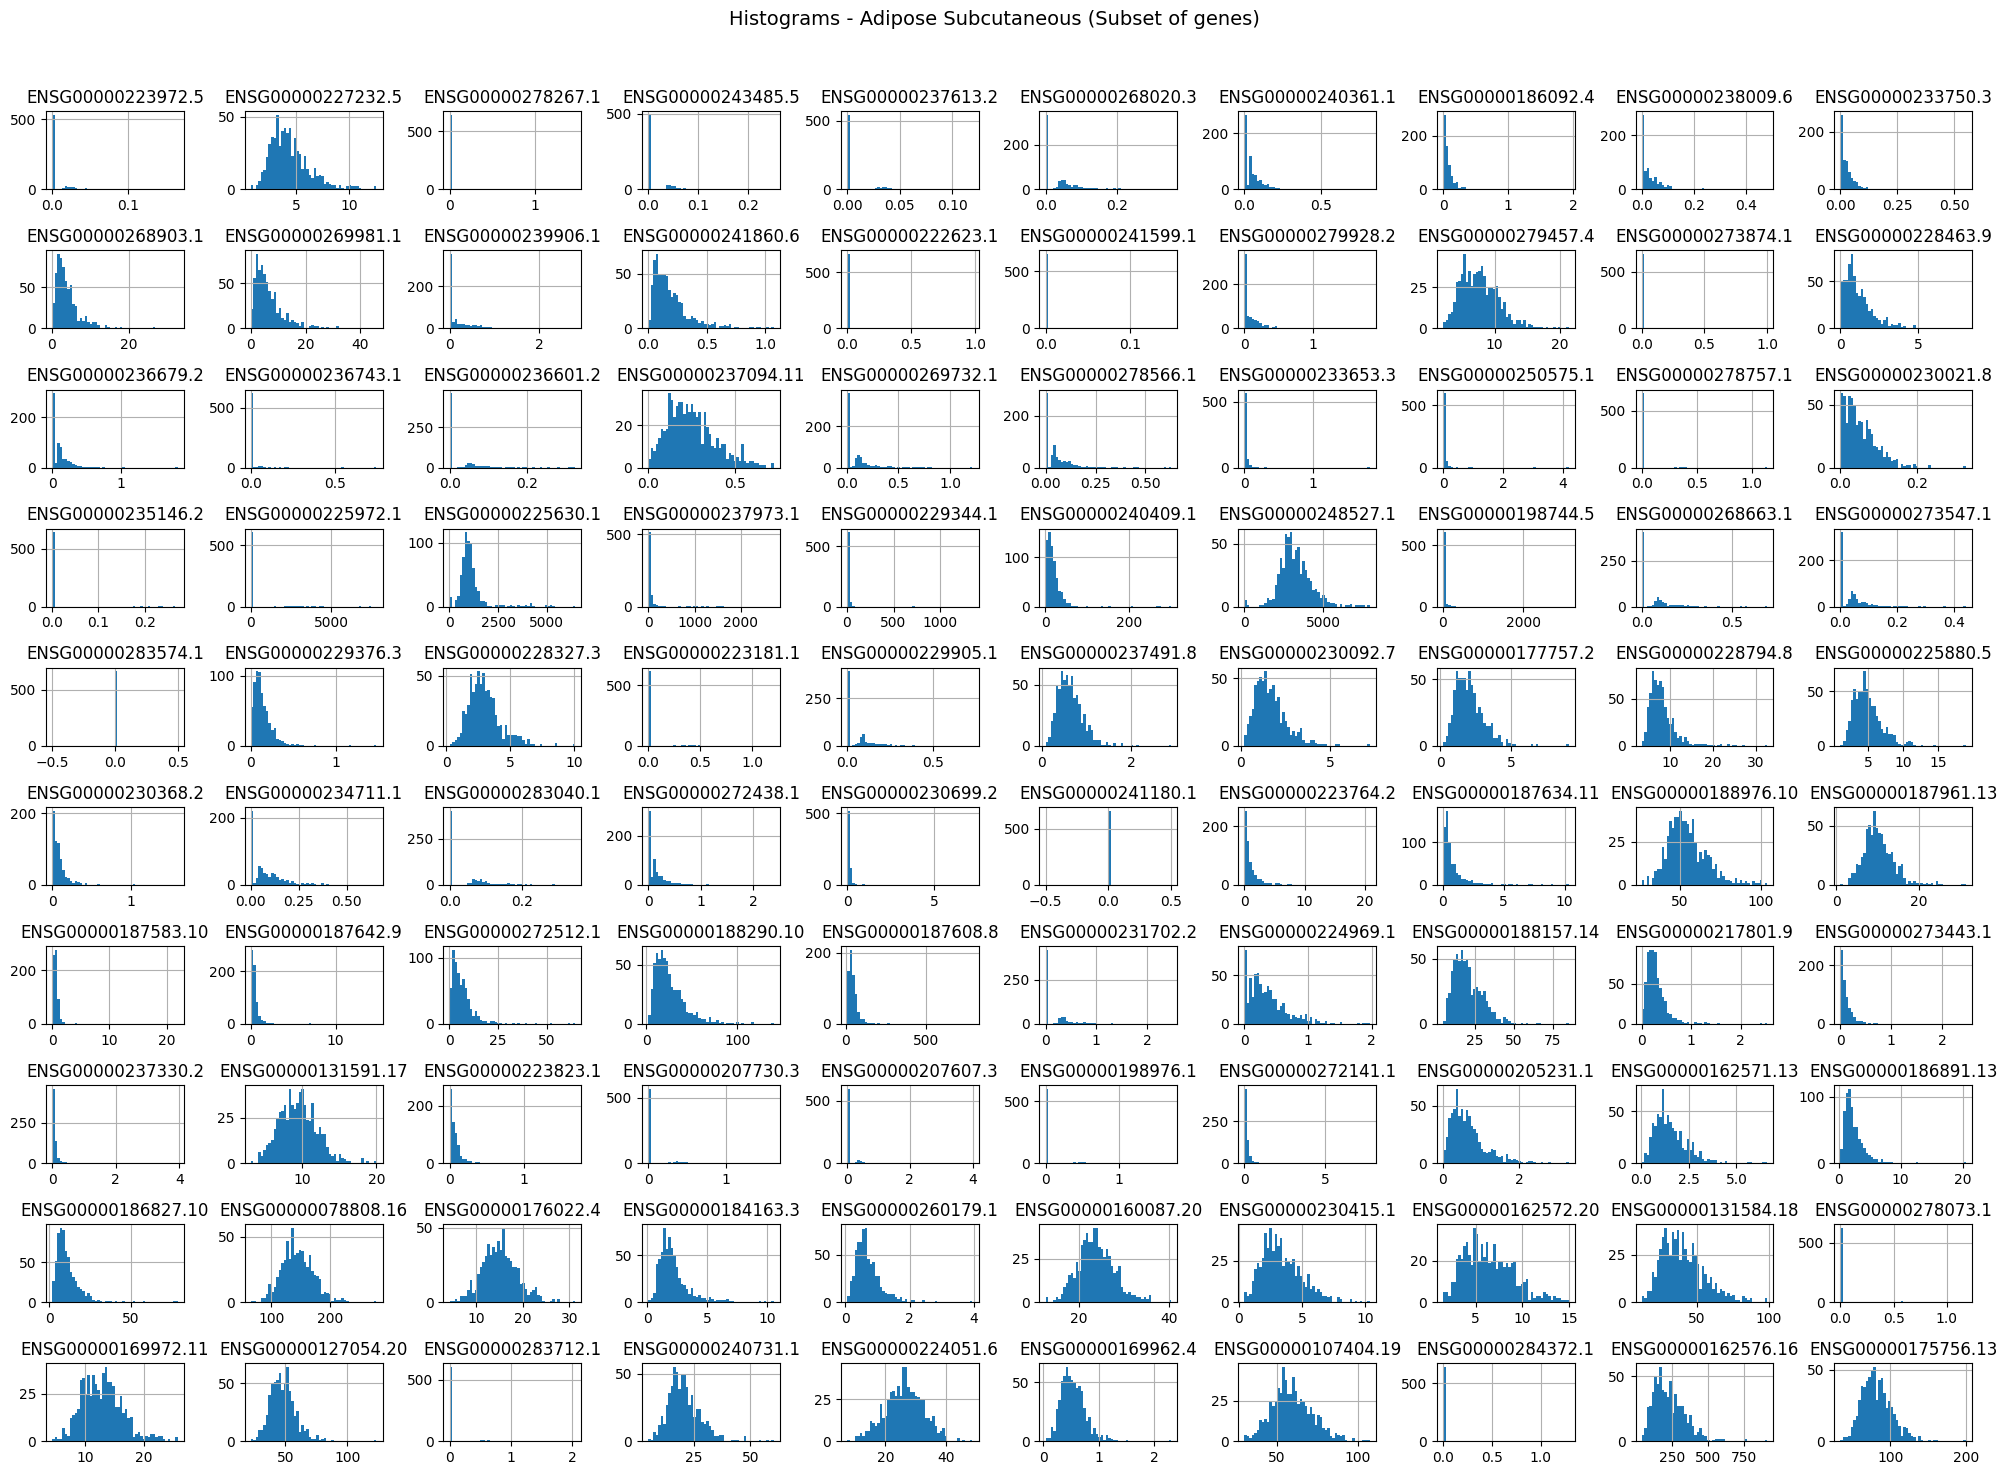

In [ ]:
X_adipose_subset.hist(bins=50, figsize=(20,15))
plt.suptitle("Histograms - Adipose Subcutaneous (Subset of genes)", size=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

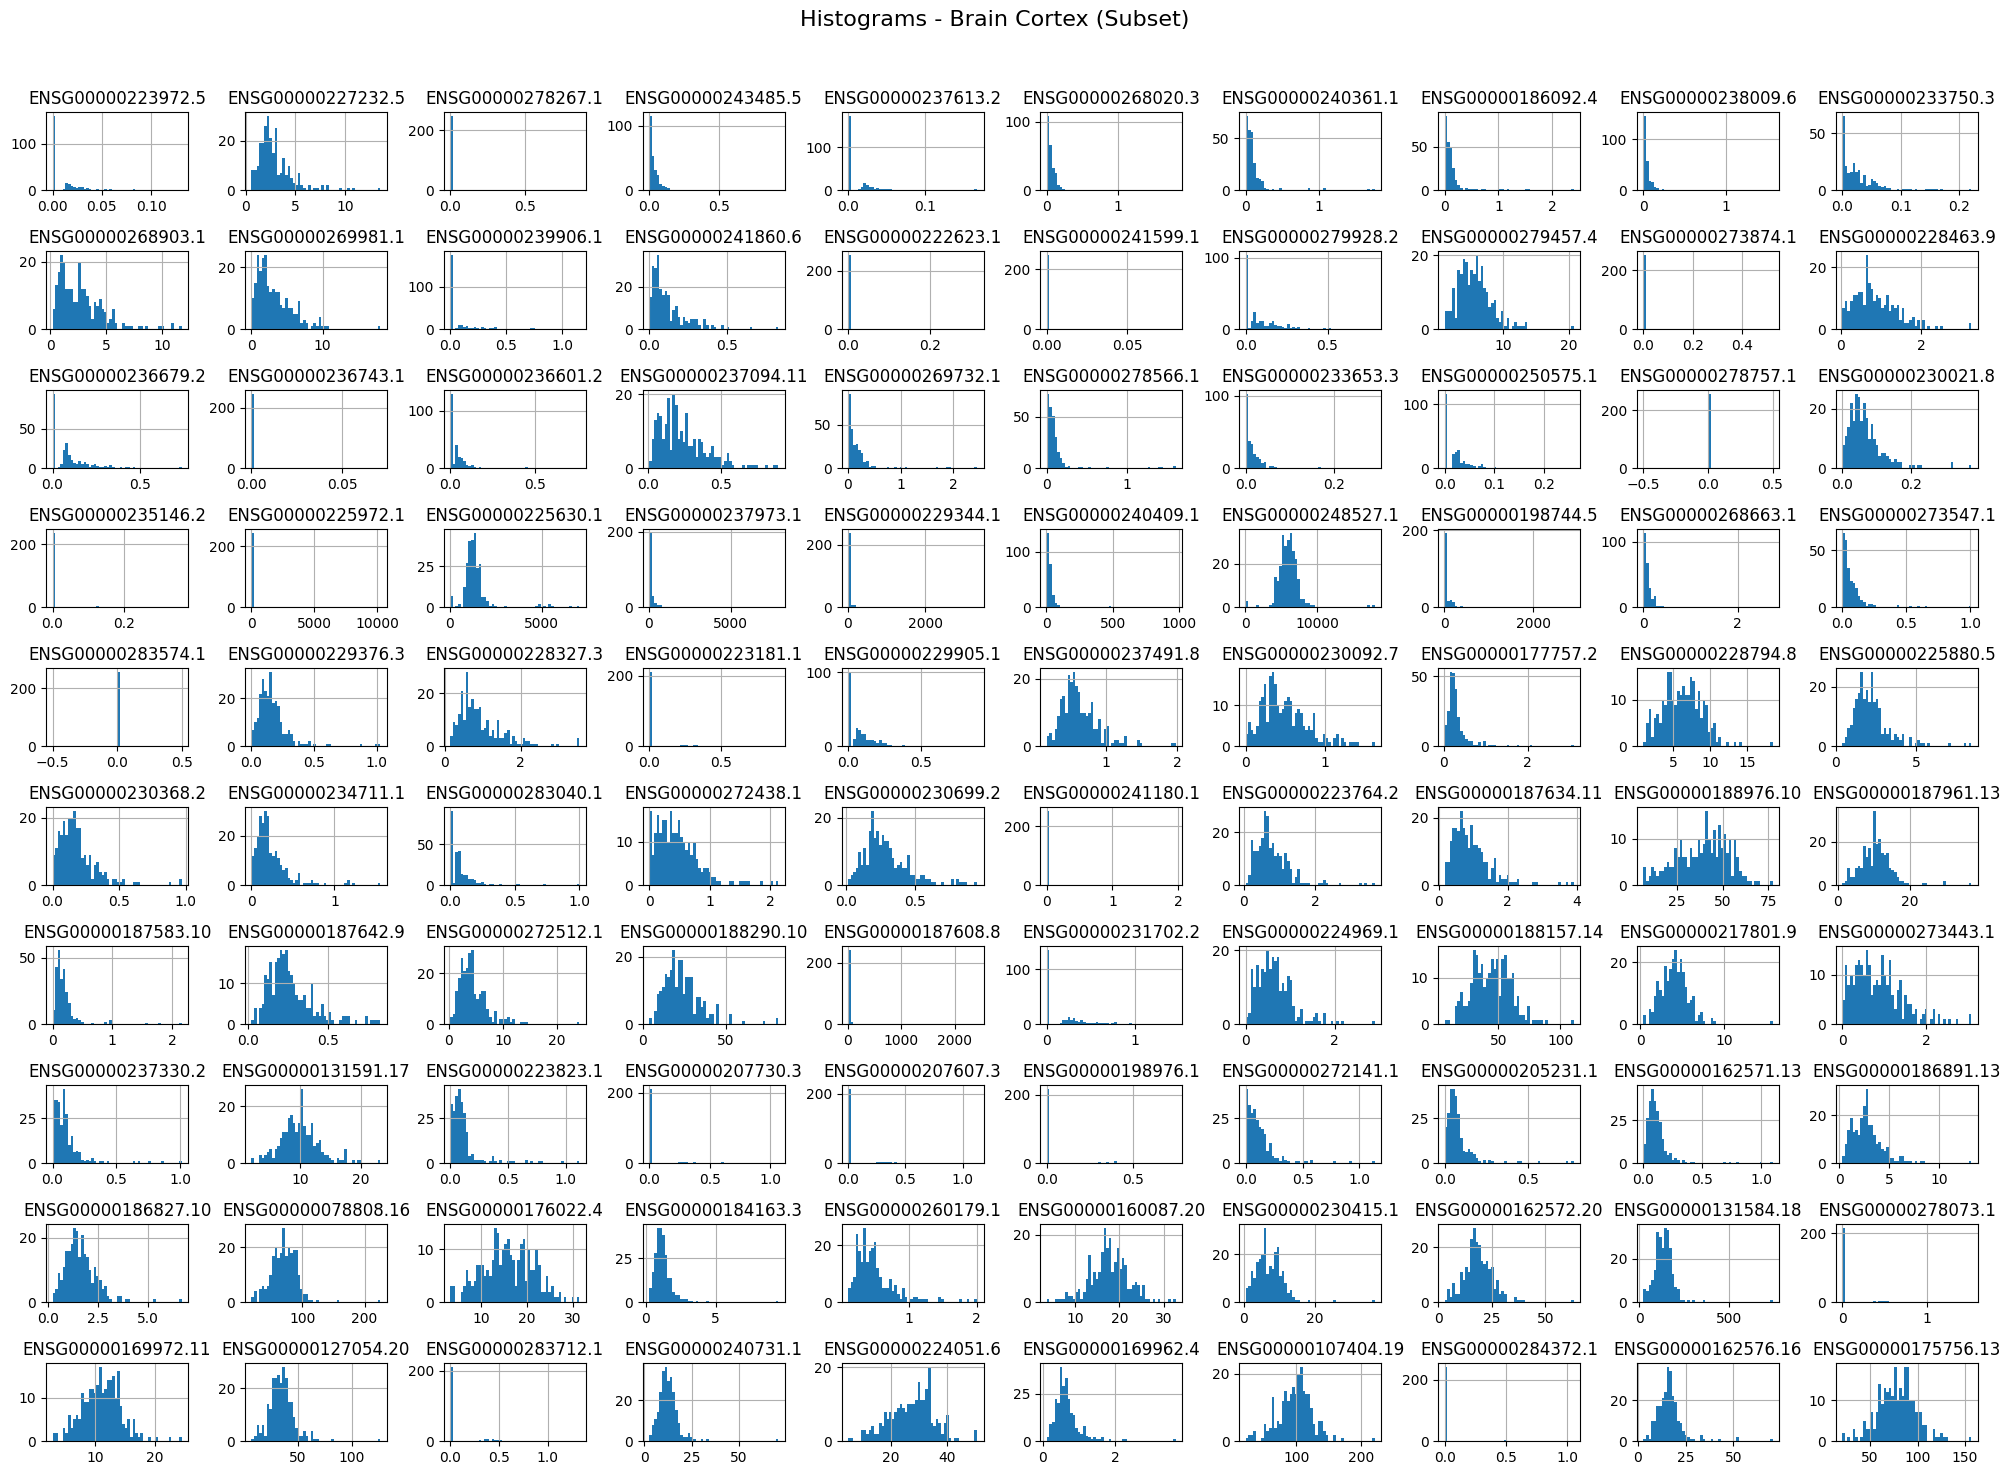

In [ ]:
X_brain_subset.hist(bins=50, figsize=(20, 15))
plt.suptitle("Histograms - Brain Cortex (Subset of genes)", size=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### c. Boxplots - Features

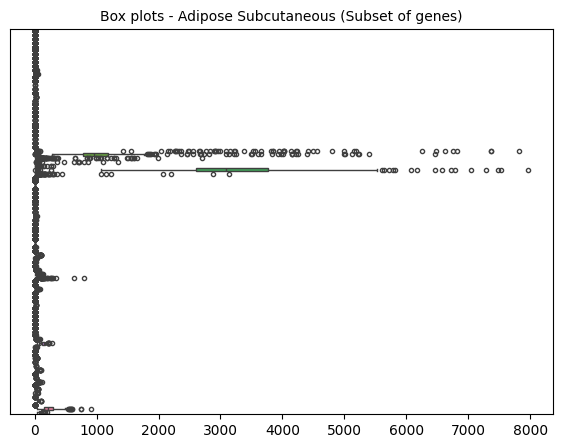

In [ ]:
# Box plots for Adipose Subcutaneous
flierprops = dict(marker='o', markersize=3)
plt.figure(figsize=(7,5))
sns.boxplot(data=X_adipose_subset, orient="h", flierprops=flierprops)
plt.title("Box plots - Adipose Subcutaneous (Subset of genes)", size=10)
plt.yticks([])  # Remove y-axis labels
plt.show()

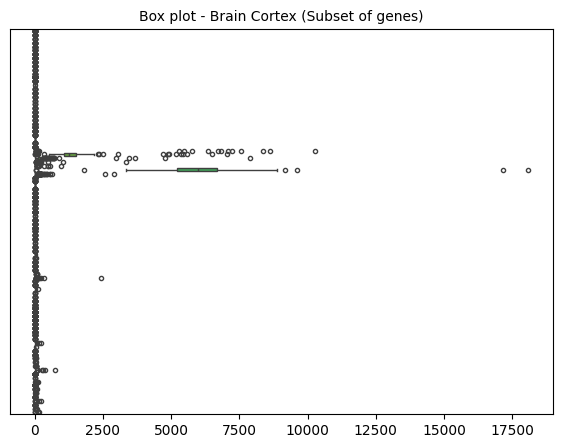

In [ ]:
# Box plots for Brain Cortex
flierprops = dict(marker='o', markersize=3)
plt.figure(figsize=(7, 5))
sns.boxplot(data=X_brain_subset, orient="h", flierprops=flierprops)
plt.title("Box plot - Brain Cortex (Subset of genes)", size=10)
plt.yticks([])  # Remove y-axis labels
plt.show()


### d. Variances - Features

In [ ]:
# Calculate variances
variances_adipose_initial = X_adipose.var()
variances_brain_initial = X_brain.var()

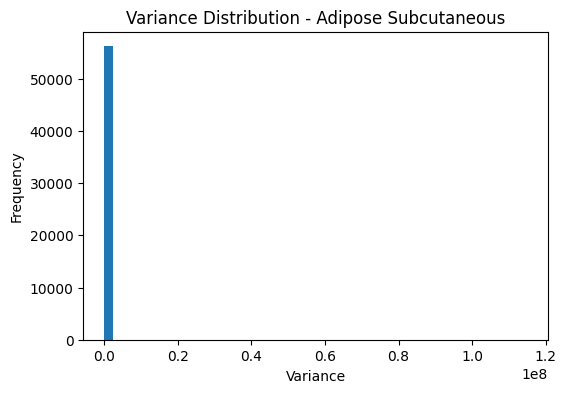

In [ ]:
# Convert to DataFrame for easier visualization
variances_adipose_df = pd.DataFrame({'Feature': X_adipose.columns, 'Variance': variances_adipose})


plt.figure(figsize=(6,4))
plt.hist(variances_adipose_df['Variance'], bins=50)
plt.title('Variance Distribution - Adipose Subcutaneous')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

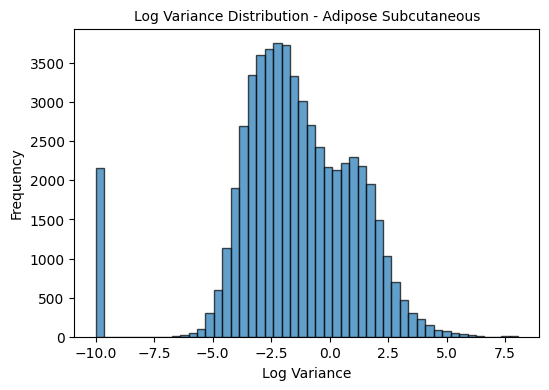

In [ ]:
# Plot the log variance distribution for Adipose Subcutaneous data
log_variances_adipose = np.log10(variances_adipose + 1e-10)  # Add a small value to avoid log(0)
plt.figure(figsize=(6,4))
plt.hist(log_variances_adipose, bins=50, edgecolor='k', alpha=0.7)
plt.title('Log Variance Distribution - Adipose Subcutaneous',size=10)
plt.xlabel('Log Variance')
plt.ylabel('Frequency')
plt.show()

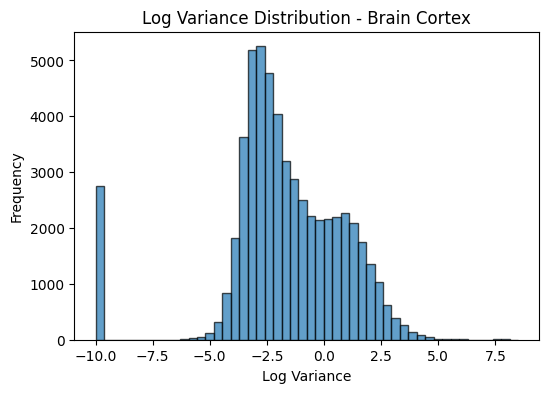

In [ ]:

# Plot the log variance distribution for Brain data
log_variances_brain = np.log10(variances_brain + 1e-10)  # Add a small value to avoid log(0)

plt.figure(figsize=(6, 4))
plt.hist(log_variances_brain, bins=50, edgecolor='k', alpha=0.7)
plt.title('Log Variance Distribution - Brain Cortex')
plt.xlabel('Log Variance')
plt.ylabel('Frequency')
plt.show()

### e. Correlation heatmaps

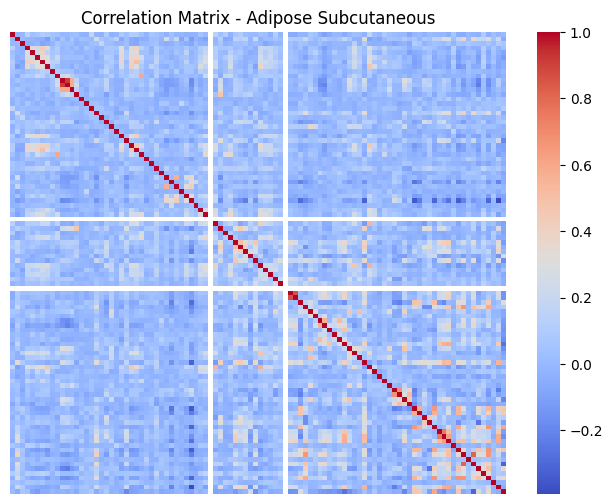

In [ ]:
plt.figure(figsize=(8,6))
corr_matrix_adipose = X_adipose_subset.corr()
sns.heatmap(corr_matrix_adipose, annot=False, cmap='coolwarm',cbar=True,xticklabels=False, yticklabels=False)
plt.title('Correlation Matrix - Adipose Subcutaneous')
plt.show()

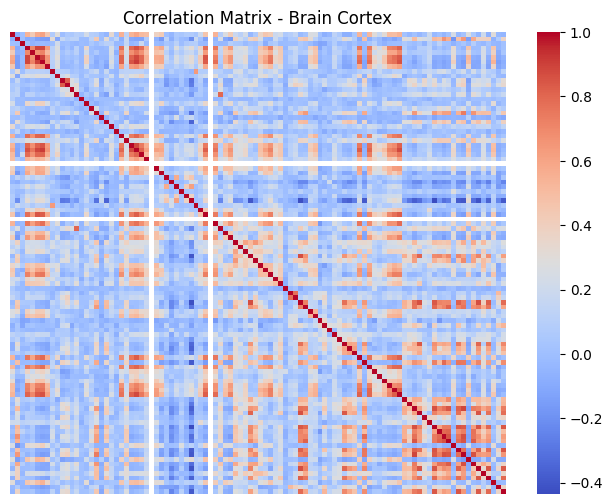

In [ ]:
plt.figure(figsize=(8,6))
corr_matrix_brain = X_brain_subset.corr()
sns.heatmap(corr_matrix_brain, annot=False, cmap='coolwarm',cbar=True,xticklabels=False, yticklabels=False)
plt.title('Correlation Matrix - Brain Cortex')
plt.show()

### f. Correlation with the target

## 2. Pre-processing

### a. Missing values

Checking for missing values in the datasets - features and target values

In [ ]:
# Features datasets
print(X_adipose.isnull().sum().sum())
print(X_brain.isnull().sum().sum())
# Target values
print(y_adipose.isnull().sum())
print(y_brain.isnull().sum())

0
0
0
0


There were no missing values neither in the feature matrices (gene values) nor in the target values.


### b. Filtering features

#### b.1. Removing features with many zero values

---



Dropping those with over 80% of their values ​​being zero

In [15]:
# Defining the function that filters the dataset
def filter_features_with_many_zeros(df, threshold):
    non_zero_counts = (df != 0).sum(axis=0)
    keep_columns = non_zero_counts[non_zero_counts >= df.shape[0] * (1 - threshold)].index
    original_feature_count = df.shape[1]
    kept_feature_count = len(keep_columns)
    dropped_feature_count = original_feature_count - kept_feature_count
    dropped_percentage = (dropped_feature_count / original_feature_count) * 100

    print(f"Number of features before filtering: {original_feature_count}")
    print(f"Number of features after filtering: {kept_feature_count}")
    print(f"Number of features dropped: {dropped_feature_count}")
    print(f"Percentage of features dropped: {dropped_percentage:.2f}%")

    return df[keep_columns]

In [16]:
# Apply to adipose raw data
print("Filtering features with many zeros - Adipose Subcutaneous dataset:\n")
X_adipose_filtered = filter_features_with_many_zeros(X_adipose, threshold=0.2)
print(f"Dimensions after filtering features: {X_adipose_filtered.shape}")

Filtering features with many zeros - Adipose Subcutaneous dataset:

Number of features before filtering: 56200
Number of features after filtering: 24220
Number of features dropped: 31980
Percentage of features dropped: 56.90%
Dimensions after filtering features: (663, 24220)


In [17]:
# Apply to brain raw data
print("Filtering features with many zeros - Brain Cortex dataset:\n")
X_brain_filtered = filter_features_with_many_zeros(X_brain, threshold=0.2)
print(f"Dimensions after filtering features: {X_brain_filtered.shape}")

Filtering features with many zeros - Brain Cortex dataset:

Number of features before filtering: 56200
Number of features after filtering: 25281
Number of features dropped: 30919
Percentage of features dropped: 55.02%
Dimensions after filtering features: (255, 25281)


#### b.2. Removing features with low variance

---



Dropping features with low variance by using a VarianceThreshold at different
percentiles, calculate the cumulative explained variance of the remaining
features, and select the optimal percentile to continue with.

In [18]:
# Defining the function that calculates the explained variance

def calculate_explained_variance(data, selector):
    # Fit the selector (VarianceThreshold) and transform the data
    filtered_data = selector.fit_transform(data)

    # Calculate the variance explained by each retained feature
    explained_variance = np.var(filtered_data, axis=0)
    total_variance = np.var(data, axis=0).sum()

    # Calculate the cumulative explained variance ratio
    cumulative_explained_variance = np.cumsum(explained_variance) / total_variance

    return cumulative_explained_variance

In [20]:
variances_adipose = X_adipose_filtered.var()
variances_brain = X_brain_filtered.var()

In [19]:
# Define different percentiles to test
percentiles = [20,40,50,60,70]

In [22]:
# Initialize lists to store results
cumulative_explained_variances_adipose = []
cumulative_explained_variances_brain = []

for p in percentiles:
    # Determine the threshold for each percentile
    threshold_adipose = np.percentile(variances_adipose, p)
    threshold_brain = np.percentile(variances_brain, p)

    # Create VarianceThreshold selectors
    selector_adipose = VarianceThreshold(threshold=threshold_adipose)
    selector_brain = VarianceThreshold(threshold=threshold_brain)

    # Calculate cumulative explained variance
    cumulative_explained_variance_adipose = calculate_explained_variance(X_adipose_filtered, selector_adipose)
    cumulative_explained_variance_brain = calculate_explained_variance(X_brain_filtered, selector_brain)

    # Store results
    cumulative_explained_variances_adipose.append(cumulative_explained_variance_adipose)
    cumulative_explained_variances_brain.append(cumulative_explained_variance_brain)

Visualizing the results

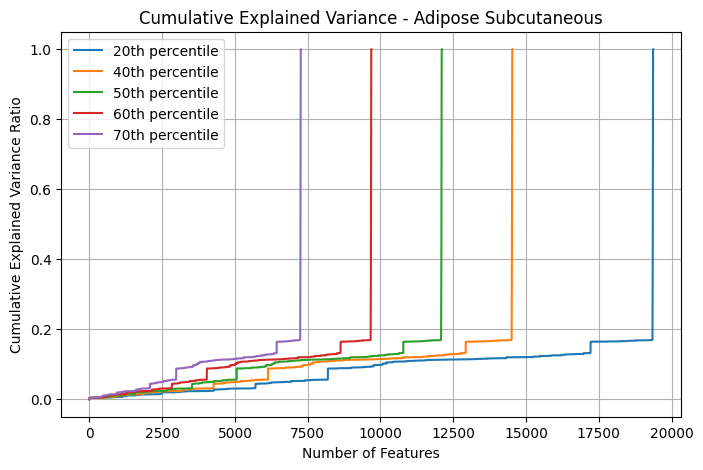

In [22]:
# Plot cumulative explained variance for Adipose data
plt.figure(figsize=(8,5))
for i, p in enumerate(percentiles):
    plt.plot(cumulative_explained_variances_adipose[i], label=f'{p}th percentile')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance - Adipose Subcutaneous')
plt.legend()
plt.grid(True)
plt.show()


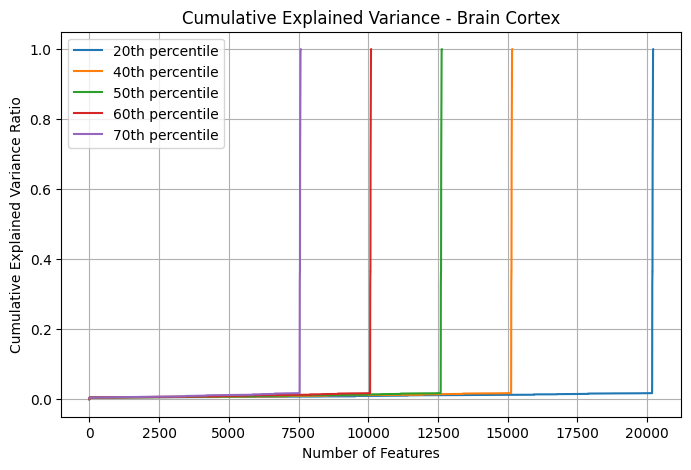

In [23]:
# Plot cumulative explained variance for Brain data
plt.figure(figsize=(8, 5))
for i, p in enumerate(percentiles):
    plt.plot(cumulative_explained_variances_brain[i], label=f'{p}th percentile')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance - Brain Cortex')
plt.legend()
plt.grid(True)
plt.show()

After reviewing the results, we decided to continue with the 70th percentile.

In [23]:
# Choose the 70th percentile as the threshold
threshold_adipose_70 = np.percentile(variances_adipose, 70)
threshold_brain_70 = np.percentile(variances_brain, 70)

print(f"Adipose 70th percentile variance threshold: {threshold_adipose_70}")
print(f"Brain 70th percentile variance threshold: {threshold_brain_70}")

# Apply variance threshold to Adipose data
selector_adipose_70 = VarianceThreshold(threshold=threshold_adipose_70)
X_adipose_var_filtered_70 = selector_adipose_70.fit_transform(X_adipose_filtered)

# Apply variance threshold to Brain data
selector_brain_70 = VarianceThreshold(threshold=threshold_brain_70)
X_brain_var_filtered_70 = selector_brain_70.fit_transform(X_brain_filtered)

# Convert back to DataFrame
selected_features_adipose_70 = X_adipose_filtered.columns[selector_adipose_70.get_support()]
selected_features_brain_70 = X_brain_filtered.columns[selector_brain_70.get_support()]

X_adipose_var_filtered_70 = pd.DataFrame(X_adipose_var_filtered_70, columns=selected_features_adipose_70)
X_brain_var_filtered_70 = pd.DataFrame(X_brain_var_filtered_70, columns=selected_features_brain_70)

Adipose 70th percentile variance threshold: 26.538177108764646
Brain 70th percentile variance threshold: 13.786504745483398


In [24]:
# Results - dimensions

initial_features_adipose = X_adipose_filtered.shape[1]
initial_features_brain = X_brain_filtered.shape[1]

retained_features_adipose = len(selected_features_adipose_70)
retained_features_brain = len(selected_features_brain_70)

# Calculate the percentage of features dropped
features_dropped_adipose = initial_features_adipose - retained_features_adipose
features_dropped_brain = initial_features_brain - retained_features_brain

percentage_dropped_adipose = (features_dropped_adipose / initial_features_adipose) * 100
percentage_dropped_brain = (features_dropped_brain / initial_features_brain) * 100

In [26]:
# The dimensions after filtering
print("Adipose Subcutaneous dataset:")
print(f"Dimensions before variance based filtering: {X_adipose_filtered.shape}")
print(f"Dimensions after variance based filtering: {X_adipose_var_filtered_70.shape}")
print(f"Percentage of features dropped: {percentage_dropped_adipose:.2f}%")

Adipose Subcutaneous dataset:
Dimensions before variance based filtering: (663, 24220)
Dimensions after variance based filtering: (663, 7262)
Percentage of features dropped: 70.02%


In [27]:
print("Brain Cortex dataset:")
print(f"Dimensions before variance based filtering: {X_brain_filtered.shape}")
print(f"Dimensions after variance based filtering: {X_brain_var_filtered_70.shape}")
print(f"Percentage of features dropped: {percentage_dropped_brain:.2f}%")

Brain Cortex dataset:
Dimensions before variance based filtering: (255, 25281)
Dimensions after variance based filtering: (255, 7573)
Percentage of features dropped: 70.04%


#### b.3. Removing features based on correlation

---



Dropping features with low correlation to the target variable

In [25]:
# Calculate the correlation of each feature with the target variable
correlation_adipose = X_adipose_var_filtered_70.corrwith(y_adipose).abs()
correlation_brain = X_brain_var_filtered_70.corrwith(y_brain).abs()

Visalize the distribution of correlations with the target

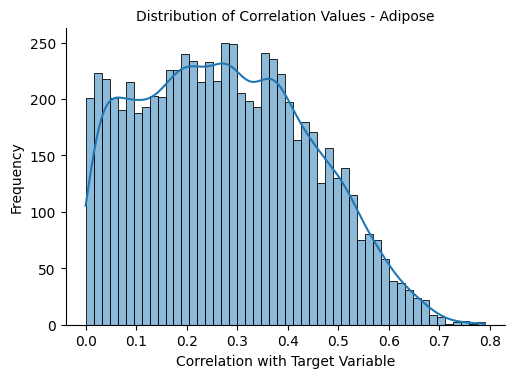

In [29]:
# Plot histogram for Adipose data

sns.displot(correlation_adipose, bins=50, kde=True, height=3.5, aspect=1.5)
plt.title('Distribution of Correlation Values - Adipose',size=10)
plt.xlabel('Correlation with Target Variable')
plt.ylabel('Frequency')
plt.show()

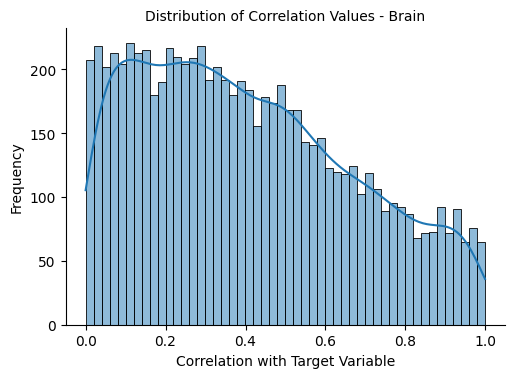

In [30]:
# Plot histogram for Brain data

sns.displot(correlation_brain, bins=50, kde=True, height=3.5, aspect=1.5)
plt.title('Distribution of Correlation Values - Brain',size=10)
plt.xlabel('Correlation with Target Variable')
plt.ylabel('Frequency')
plt.show()

After viewing the results, we decided to drop features with correlation lower than 0.2, that is to set the threshold to 0.2

In [26]:
# Set a threshold for correlation based on the distribution
correlation_threshold = 0.2

# Filter features based on correlation threshold
in_adipose = correlation_adipose[correlation_adipose > correlation_threshold].index
in_brain = correlation_brain[correlation_brain > correlation_threshold].index

# Create new DataFrames with selected features
X_adipose_cor_fil = X_adipose_var_filtered_70[in_adipose]
X_brain_cor_fil = X_brain_var_filtered_70[in_brain]

Results after filtering

In [32]:
# Calculate initial and final dimensions
initial_adipose_features = X_adipose_var_filtered_70.shape[1]
final_adipose_features = X_adipose_cor_fil.shape[1]
initial_brain_features = X_brain_var_filtered_70.shape[1]
final_brain_features = X_brain_cor_fil.shape[1]

# Calculate reduction percentage
adipose_reduction_percentage = ((initial_adipose_features - final_adipose_features) / initial_adipose_features) * 100
brain_reduction_percentage = ((initial_brain_features - final_brain_features) / initial_brain_features) * 100

In [33]:
# Print the dimensions and reduction percentages
print("Adipose Subcutaneous dataset:")
print(f"Dimensions before correlation based filtering: {X_adipose_var_filtered_70.shape}")
print(f"Dimensions after correlation based filtering: {X_adipose_cor_fil.shape}")
print(f"Percentage reduction in Adipose features: {adipose_reduction_percentage:.2f}%\n")

Adipose Subcutaneous dataset:
Dimensions before correlation based filtering: (663, 7262)
Dimensions after correlation based filtering: (663, 4636)
Percentage reduction in Adipose features: 36.16%



In [34]:
print("Brain Cortex dataset:")
print(f"Dimensions before correlation based filtering: {X_brain_var_filtered_70.shape}")
print(f"Dimensions after correlation based filtering: {X_brain_cor_fil.shape}")
print(f"Percentage reduction in Brain features: {brain_reduction_percentage:.2f}%\n")

Brain Cortex dataset:
Dimensions before correlation based filtering: (255, 7573)
Dimensions after correlation based filtering: (255, 5509)
Percentage reduction in Brain features: 27.25%



### c. Detecting and Handling Outliers

We detected outliers (across observation) using Isolation Forest and removed them.

and to do that we first transformed the data with LOG transformation.

In [27]:
#LOG Transformation and skewness

# Function to apply log1p transformation and check skewness
def apply_log_transform_and_check_skewness(df, df_name):
    # Apply log1p transformation
    df_log = np.log1p(df)

    # Calculate skewness before and after transformation
    skewness_before = df.skew()
    skewness_after = df_log.skew()

    # Print skewness summaries
    print(f"Skewness Summary for {df_name} Before Log Transformation:\n")
    print(skewness_before.describe())
    print(f"\nIndividual Feature Skewness for {df_name} Before Log Transformation:\n")
    print(skewness_before)

    print(f"\nSkewness Summary for {df_name} After Log Transformation:\n")
    print(skewness_after.describe())
    print(f"\nIndividual Feature Skewness for {df_name} After Log Transformation:\n")
    print(skewness_after)

    return df_log


X_adipose_log = apply_log_transform_and_check_skewness(X_adipose_cor_fil, "X_adipose_cor_fil")
X_brain_log = apply_log_transform_and_check_skewness(X_brain_cor_fil, "X_brain_cor_fil")

Skewness Summary for X_adipose_cor_fil Before Log Transformation:

count    4636.000000
mean        1.863825
std         2.908444
min        -0.266626
25%         0.651894
50%         1.093481
75%         1.841989
max        25.600704
dtype: float64

Individual Feature Skewness for X_adipose_cor_fil Before Log Transformation:

ENSG00000237973.1      5.427554
ENSG00000229344.1      9.332149
ENSG00000198744.5     10.914600
ENSG00000188290.10     1.903748
ENSG00000131584.18     0.816492
                        ...    
ENSG00000198899.2      0.456309
ENSG00000198840.2      0.711245
ENSG00000212907.2      0.377910
ENSG00000198886.2      0.308702
ENSG00000198727.2      0.341500
Length: 4636, dtype: float32

Skewness Summary for X_adipose_cor_fil After Log Transformation:

count    4636.000000
mean        0.022268
std         0.726351
min        -2.869034
25%        -0.304695
50%        -0.087891
75%         0.171525
max        12.615023
dtype: float64

Individual Feature Skewness for X_adipo

Identifing outliers using Isolation Forest

In [28]:
# For adipose
iso_forest = IsolationForest(contamination=0.03, random_state=42)
iso_forest.fit(X_adipose_log)
predictions_adipose = iso_forest.predict(X_adipose_log)

num_outliers_adipose = (predictions_adipose == -1).sum()
num_inliers_adipose = (predictions_adipose == 1).sum()

print("Adipose Subcutaneous dataset:")
print(f"Number of outliers: {num_outliers_adipose} out of {X_adipose_log.shape[0]}")
print(f"Number of inliers: {num_inliers_adipose}")

Adipose Subcutaneous dataset:
Number of outliers: 20 out of 663
Number of inliers: 643


In [29]:
# For brain
iso_forest.fit(X_brain_log)
predictions_brain = iso_forest.predict(X_brain_log)

num_outliers_brain = (predictions_brain == -1).sum()
num_inliers_brain = (predictions_brain == 1).sum()

print("Brain Cortex dataset:")
print(f"Number of outliers: {num_outliers_brain} out of {X_brain_log.shape[0]}")
print(f"Number of inliers: {num_inliers_brain}")

Brain Cortex dataset:
Number of outliers: 8 out of 255
Number of inliers: 247


Dropping outliers - observations

In [30]:
# Removing outliers
X_adipose_transformed_cleaned = X_adipose_log[predictions_adipose == 1]
X_brain_transformed_cleaned = X_brain_log[predictions_brain == 1]

# Update the target variable after dropping observations
y_adipose_cleaned = y_adipose[predictions_adipose == 1]
y_brain_cleaned = y_brain[predictions_brain == 1]

# Calculate reduction percentage
adipose_outliers_percentage = (num_outliers_adipose/ X_adipose_log.shape[0]) * 100
brain_outliers_percentage = (num_outliers_brain / X_brain_log.shape[0]) * 100

In [39]:
print("Adipose Subcutaneous dataset:")
print(f"Dimensions before dropping outliers: {X_adipose_cor_fil.shape}")
print(f"Dimensions after dropping outliers: {X_adipose_transformed_cleaned.shape}")
print(f"Percentage of outliers out of intial observations number: {adipose_outliers_percentage:.2f}%\n")


print("Brain Cortex dataset:")
print(f"Dimensions before dropping outliers: {X_brain_cor_fil.shape}")
print(f"Dimensions after dropping outliers:  {X_brain_transformed_cleaned.shape}")
print(f"Percentage of outliers out of initial observations number: {brain_outliers_percentage:.2f}%")

Adipose Subcutaneous dataset:
Dimensions before dropping outliers: (663, 4636)
Dimensions after dropping outliers: (643, 4636)
Percentage of outliers out of intial observations number: 3.02%

Brain Cortex dataset:
Dimensions before dropping outliers: (255, 5509)
Dimensions after dropping outliers:  (247, 5509)
Percentage of outliers out of initial observations number: 3.14%


Comparing features before and after the LOG transformation

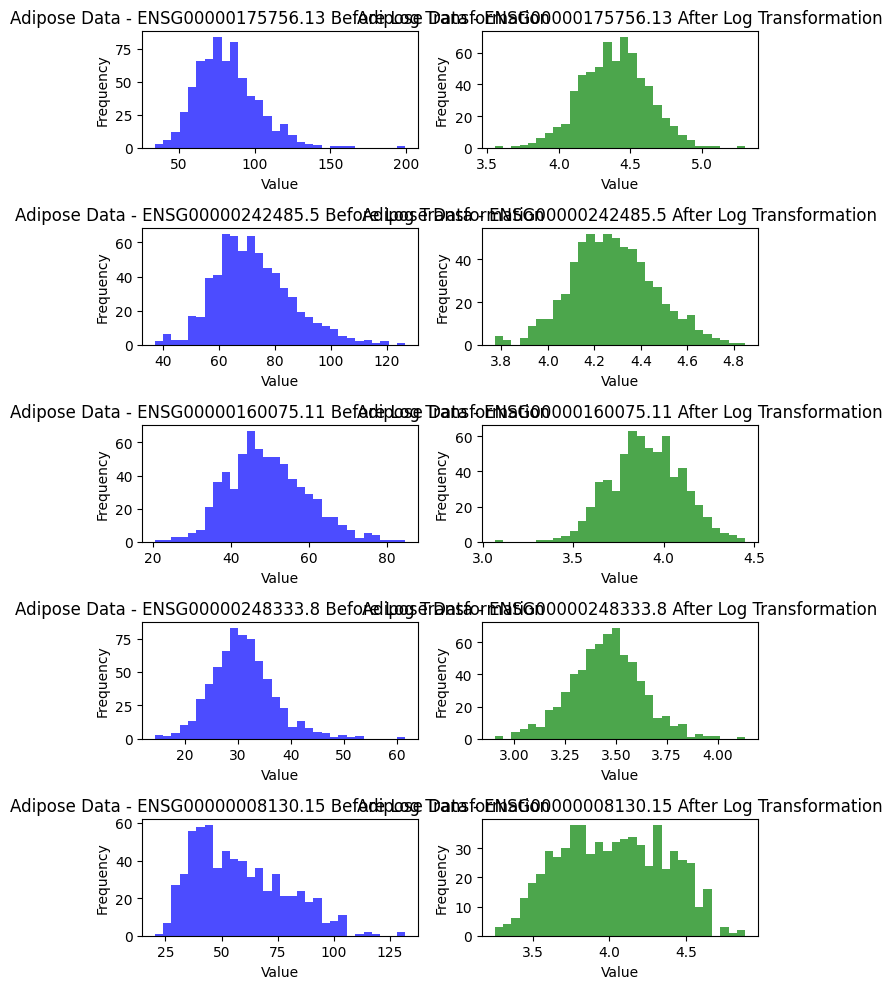

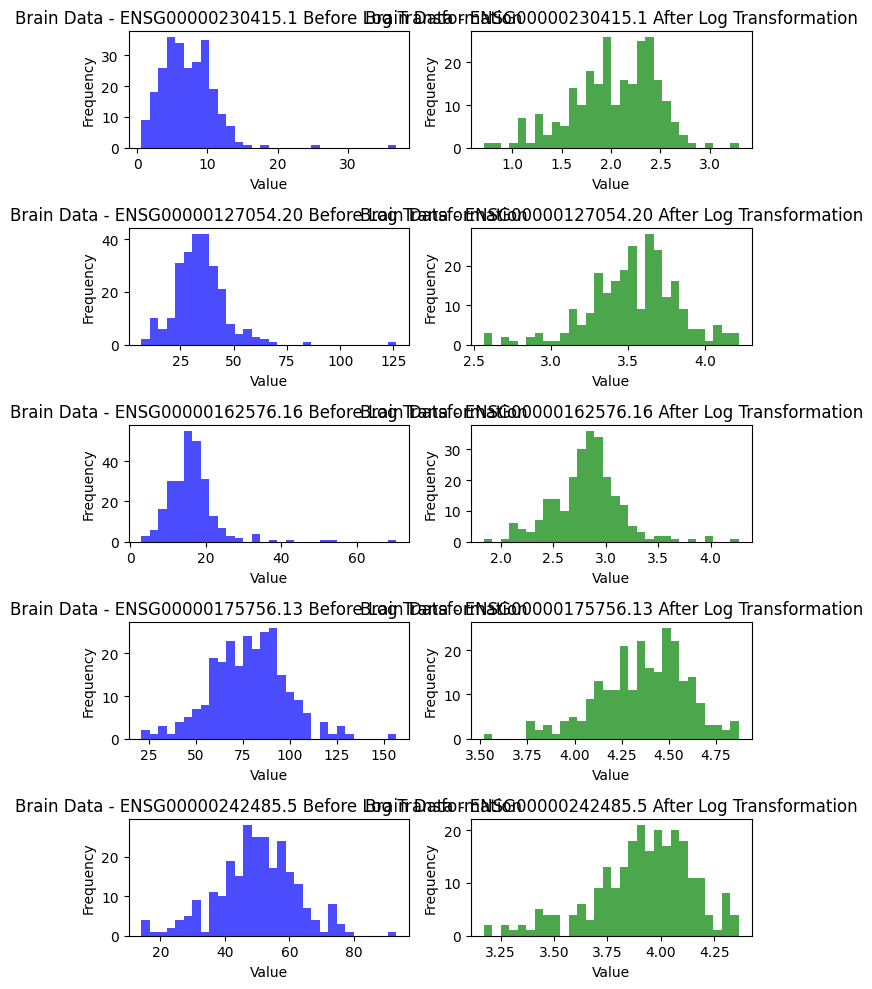

In [31]:
# Histograms - distributions
# Function to compare distributions of features
def compare_feature_distributions(original, transformed, features, title):
    fig, axes = plt.subplots(len(features), 2, figsize=(7, 2 * len(features)))

    for i, feature in enumerate(features):
        # Plot the distribution of the feature before transformation
        axes[i, 0].hist(original[feature], bins=30, color='blue', alpha=0.7)
        axes[i, 0].set_title(f'{title} - {feature} Before Log Transformation')
        axes[i, 0].set_xlabel('Value')
        axes[i, 0].set_ylabel('Frequency')

        # Plot the distribution of the feature after transformation
        axes[i, 1].hist(transformed[feature], bins=30, color='green', alpha=0.7)
        axes[i, 1].set_title(f'{title} - {feature} After Log Transformation')
        axes[i, 1].set_xlabel('Value')
        axes[i, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Compare distributions for a subset of features
features = X_adipose_cor_fil.columns[10:15]
compare_feature_distributions(X_adipose_cor_fil, X_adipose_transformed_cleaned, features, 'Adipose Data')

features = X_brain_cor_fil.columns[10:15]
compare_feature_distributions(X_brain_cor_fil, X_brain_transformed_cleaned, features, 'Brain Data')

## 3. Data Normalization

We used Quantile Normalization - to get consistent ditribution across observations

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# Function that normalize the data
def normalize_data(df):
    transformer = QuantileTransformer(output_distribution='normal', random_state=42)
    df_normalized = pd.DataFrame(transformer.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized

# Normalize adipose data
X_adipose_normalized = normalize_data(X_adipose_transformed_cleaned)

# Normalize brain data
X_brain_normalized = normalize_data(X_brain_transformed_cleaned)

In [33]:
# Observations before and after Normalization

# Select a small sample of observations to check normalization
sample_adipose_before = X_adipose_transformed_cleaned.iloc[:15, :15]
sample_adipose_after = X_adipose_normalized.iloc[:15, :15]

sample_brain_before = X_brain_transformed_cleaned.iloc[:15, :15]
sample_brain_after = X_brain_normalized.iloc[:15, :15]

# Function to plot data distributions for a small sample with rotation
def plot_sample_data(df, title):
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.boxplot(df.values, vert=True, patch_artist=True)
    ax.set_title(title)
    ax.set_xticklabels(df.index, rotation=90)
    plt.tight_layout()
    plt.show()

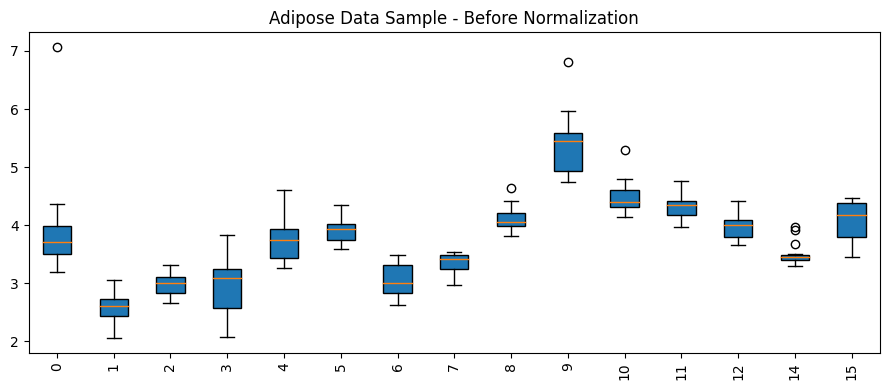

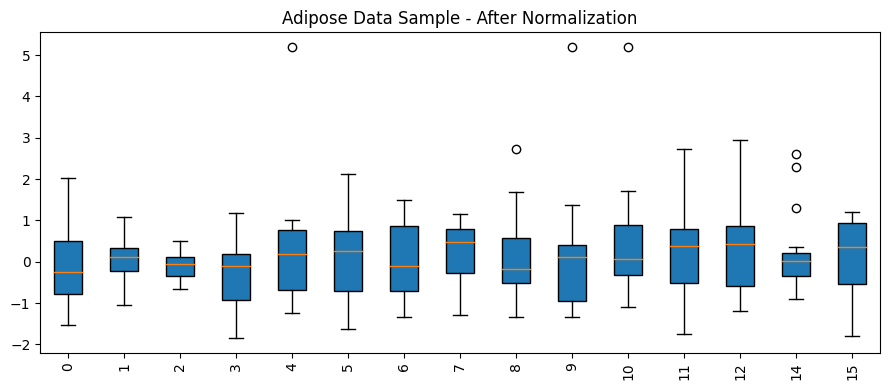

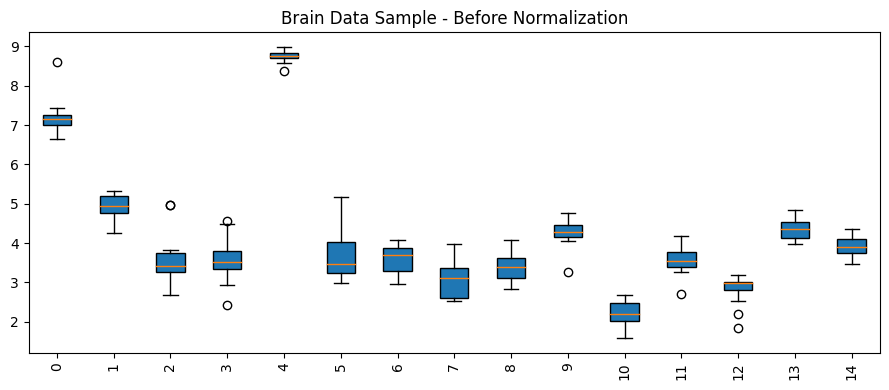

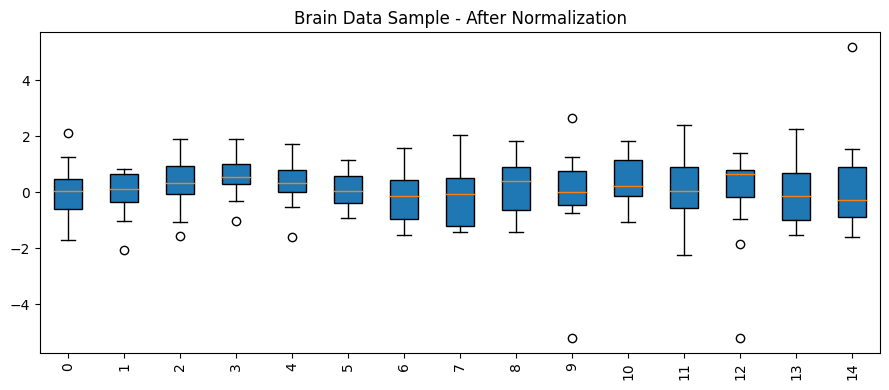

In [34]:
# Plot data for a sample of adipose data before normalization
plot_sample_data(sample_adipose_before, 'Adipose Data Sample - Before Normalization')

# Plot data for a sample of adipose data after normalization
plot_sample_data(sample_adipose_after, 'Adipose Data Sample - After Normalization')

# Plot data for a sample of brain data before normalization
plot_sample_data(sample_brain_before, 'Brain Data Sample - Before Normalization')

# Plot data for a sample of brain data after normalization
plot_sample_data(sample_brain_after, 'Brain Data Sample - After Normalization')

In [35]:
# Select a small sample of observations to check normalization
sample_adipose_before = X_adipose_transformed_cleaned.iloc[:15, :15]
sample_adipose_after = X_adipose_normalized.iloc[:15, :15]

sample_brain_before = X_brain_transformed_cleaned.iloc[:15, :15]
sample_brain_after = X_brain_normalized.iloc[:15, :15]

# Function to plot data distributions for a small sample with rotation
def plot_sample_data(df, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.boxplot(df.T.values, vert=True, patch_artist=True)
    ax.set_title(title)
    ax.set_xticklabels(df.columns, rotation=90)
    plt.tight_layout()
    plt.show()

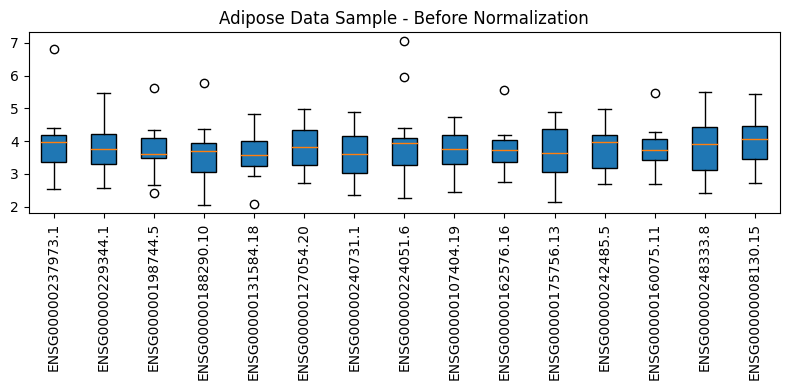

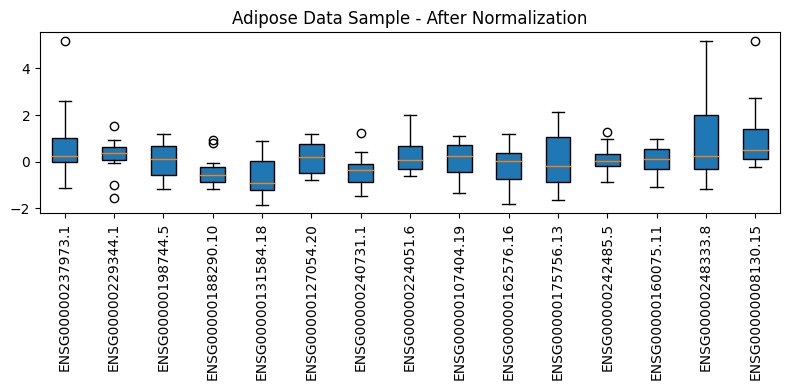

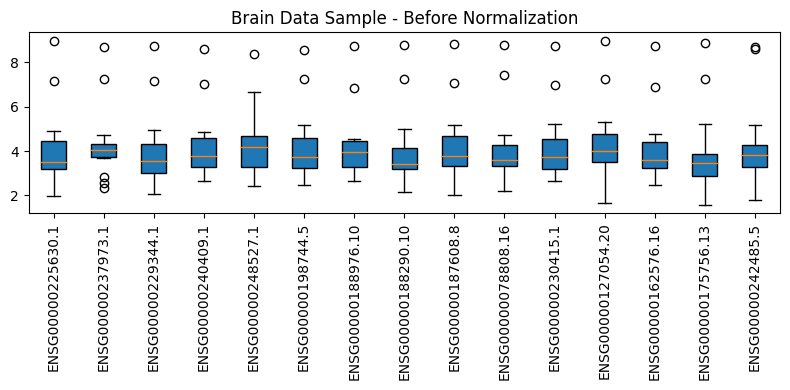

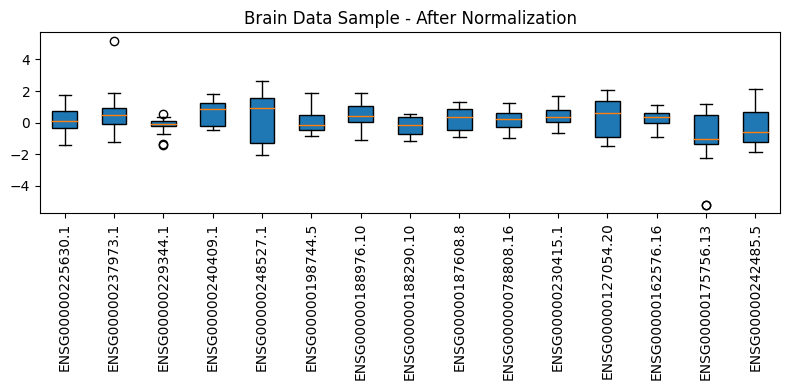

In [36]:
# Plot data for a sample of adipose data before normalization
plot_sample_data(sample_adipose_before, 'Adipose Data Sample - Before Normalization')

# Plot data for a sample of adipose data after normalization
plot_sample_data(sample_adipose_after, 'Adipose Data Sample - After Normalization')

# Plot data for a sample of brain data before normalization
plot_sample_data(sample_brain_before, 'Brain Data Sample - Before Normalization')

# Plot data for a sample of brain data after normalization
plot_sample_data(sample_brain_after, 'Brain Data Sample - After Normalization')

## 4. Feature selection

We used LASSO to select the most relevant features

LASSO helps with removing highly correlated features and dimension reduction

In [37]:
lasso_adipose = LassoCV(cv=10, max_iter=10000, random_state=0).fit(X_adipose_normalized, y_adipose_cleaned)

# Get the coefficients and corresponding feature names
adipose_coef = pd.Series(lasso_adipose.coef_, index=X_adipose_normalized.columns)

# Select features with non-zero coefficients
adipose_selected_features = adipose_coef[adipose_coef != 0].index.tolist()

In [38]:
lasso_brain = LassoCV(cv=10, max_iter=10000, random_state=0).fit(X_brain_normalized, y_brain_cleaned)

# Get the coefficients and corresponding feature names
brain_coef = pd.Series(lasso_brain.coef_, index=X_brain_normalized.columns)

# Select features with non-zero coefficients
brain_selected_features = brain_coef[brain_coef != 0].index.tolist()

In [39]:
# Display the number of selected features
adipose_feature_per = (len(adipose_selected_features) / X_adipose_normalized.shape[1]) * 100
brain_feature_per = (len(brain_selected_features) / X_brain_normalized.shape[1]) * 100

print(f"Number of selected features for Adipose data: {len(adipose_selected_features)}, which is {adipose_feature_per:.2f}% of the features")
print(f"Number of selected features for Brain data: {len(brain_selected_features)}, which is {brain_feature_per:.2f}% of the features")


Number of selected features for Adipose data: 168, which is 3.62% of the features
Number of selected features for Brain data: 13, which is 0.24% of the features


## 5. Split the data

Splitting the data into Training & Testing sets

In [41]:
#ADIPOSE

# Select the features from the normalized data
X_adipose_selected = X_adipose_normalized[adipose_selected_features]

# Split the data into training and testing sets
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_adipose_selected, y_adipose_cleaned, test_size=0.2, random_state=0)

In [42]:
#BRAIN

# Select the features from the normalized data
X_brain_selected = X_brain_normalized[brain_selected_features]

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_brain_selected, y_brain_cleaned, test_size=0.2, random_state=0)

## 5. Standarization

In [44]:
# Standardize the features

# Initialize and fit the scaler for adipose data
scaler_adipose = StandardScaler()
X_a_train_stand = scaler_adipose.fit_transform(X_train_a)
X_a_test_stand = scaler_adipose.transform(X_test_a)

# Initialize and fit the scaler for brain data
scaler_brain = StandardScaler()
X_b_train_stand = scaler_brain.fit_transform(X_train_b)
X_b_test_stand = scaler_brain.transform(X_test_b)

## 6. Model fitting

In [48]:

# 1- Ridge regression  - adipose
from sklearn.model_selection import KFold

# Initial Approach: Using a Wide Range of Alphas

# Define the alphas for RidgeCV
alphas = np.logspace(-4, 4, 200)              #(0, 3, 50)              #(-6, 6, 13)

# Initialize the Ridge model with K-Fold CV
kf = KFold(n_splits=10, random_state=42, shuffle=True)
ridge_model = RidgeCV(alphas=alphas, cv=kf)

# Train the model using K-Fold CV
ridge_model.fit(X_adipose_train_stand, y_train)

# Print the chosen alpha value
print(f"Chosen alpha: {ridge_model.alpha_}")

# Make predictions
y_ridge_pred_train = ridge_model.predict(X_adipose_train_stand)
y_ridge_pred_test = ridge_model.predict(X_adipose_test_stand)

# Evaluate the model
ridge_mse_train = mean_squared_error(y_train, y_ridge_pred_train)
ridge_mse_test = mean_squared_error(y_test, y_ridge_pred_test)
ridge_r2_train = r2_score(y_train, y_ridge_pred_train)
ridge_r2_test = r2_score(y_test, y_ridge_pred_test)

print(f"Ridge Training Mean Squared Error: {ridge_mse_train}")
print(f"Ridge Testing Mean Squared Error: {ridge_mse_test}")
print(f"Ridge Training R^2: {ridge_r2_train}")
print(f"Ridge Testing R^2: {ridge_r2_test}")


Chosen alpha: 56.07169938205458
Ridge Training Mean Squared Error: 18885.871263263303
Ridge Testing Mean Squared Error: 38565.81441660141
Ridge Training R^2: 0.856894800686255
Ridge Testing R^2: 0.7155602192864947


In [49]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Ridge Regression
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_adipose_train_stand, y_train)
best_ridge = ridge_grid_search.best_estimator_

In [50]:
# Evaluate Ridge Regression
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge Regression Mean Squared Error: {mse_ridge}')
print(f'Best Ridge Model: {best_ridge}')

Ridge Regression Mean Squared Error: 44861.70349473758
Best Ridge Model: Ridge(alpha=100)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [54]:
# Evaluate Ridge Regression
y_train_pred_ridge = best_ridge.predict(X_adipose_train_stand)
y_test_pred_ridge = best_ridge.predict(X_adipose_test_stand)

mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

print(f'Ridge Regression Training Mean Squared Error: {mse_train_ridge}')
print(f'Ridge Regression Testing Mean Squared Error: {mse_test_ridge}')
print(f'Ridge Regression Training R²: {r2_train_ridge}')
print(f'Ridge Regression Testing R²: {r2_test_ridge}')
print(f'Best Ridge Model: {best_ridge}')

Ridge Regression Training Mean Squared Error: 20858.95115471803
Ridge Regression Testing Mean Squared Error: 36000.932954771764
Ridge Regression Training R²: 0.8419440479678559
Ridge Regression Testing R²: 0.7344773439886483
Best Ridge Model: Ridge(alpha=100)


In [55]:
from sklearn.model_selection import GridSearchCV

# Additional hyperparameters
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100, 200, 300, 400, 500]}
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_adipose_train_stand, y_train)
best_ridge = ridge_grid_search.best_estimator_

# Evaluate the best Ridge model with cross-validation
y_train_pred_ridge = best_ridge.predict(X_adipose_train_stand)
y_test_pred_ridge = best_ridge.predict(X_adipose_test_stand)

mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

print(f'Ridge Regression Training Mean Squared Error: {mse_train_ridge}')
print(f'Ridge Regression Testing Mean Squared Error: {mse_test_ridge}')
print(f'Ridge Regression Training R²: {r2_train_ridge}')
print(f'Ridge Regression Testing R²: {r2_test_ridge}')
print(f'Best Ridge Model: {best_ridge}')


Ridge Regression Training Mean Squared Error: 20858.95115471803
Ridge Regression Testing Mean Squared Error: 36000.932954771764
Ridge Regression Training R²: 0.8419440479678559
Ridge Regression Testing R²: 0.7344773439886483
Best Ridge Model: Ridge(alpha=100)


##Adipse dataset - models

### 1. Gradient Boosting Regressor with Hyperparameter Tuning and Cross Validation


In [60]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid for Gradient Boosting
gb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Perform grid search with cross-validation
gb_grid_search = GridSearchCV(gbr, gb_params, cv=5, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_a_train_stand, y_train_a)
best_gbr = gb_grid_search.best_estimator_

# Evaluate the best Gradient Boosting model
y_train_pred_gbr = best_gbr.predict(X_a_train_stand)
y_test_pred_gbr = best_gbr.predict(X_a_test_stand)

mse_train_gbr = mean_squared_error(y_train_a, y_train_pred_gbr)
mse_test_gbr = mean_squared_error(y_test_a, y_test_pred_gbr)
r2_train_gbr = r2_score(y_train_a, y_train_pred_gbr)
r2_test_gbr = r2_score(y_test_a, y_test_pred_gbr)

print(f'Gradient Boosting Regressor Training Mean Squared Error: {mse_train_gbr}')
print(f'Gradient Boosting Regressor Testing Mean Squared Error: {mse_test_gbr}')
print(f'Gradient Boosting Regressor Training R²: {r2_train_gbr}')
print(f'Gradient Boosting Regressor Testing R²: {r2_test_gbr}')
print(f'Best Gradient Boosting Model: {best_gbr}')


Gradient Boosting Regressor Training Mean Squared Error: 778.7718180070624
Gradient Boosting Regressor Testing Mean Squared Error: 54476.83847647692
Gradient Boosting Regressor Training R²: 0.9940989592334767
Gradient Boosting Regressor Testing R²: 0.598209444695563
Best Gradient Boosting Model: GradientBoostingRegressor(n_estimators=200)


In [63]:
# Define the extended parameter grid for Gradient Boosting
extended_gb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': [None, 'sqrt']
}

# Perform grid search with cross-validation
extended_gb_grid_search = GridSearchCV(gbr, extended_gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
extended_gb_grid_search.fit(X_a_train_stand, y_train_a)
best_extended_gbr = extended_gb_grid_search.best_estimator_

# Evaluate the best extended Gradient Boosting model
y_train_pred_extended_gbr = best_extended_gbr.predict(X_a_train_stand)
y_test_pred_extended_gbr = best_extended_gbr.predict(X_a_test_stand)

mse_train_extended_gbr = mean_squared_error(y_train_a, y_train_pred_extended_gbr)
mse_test_extended_gbr = mean_squared_error(y_test_a, y_test_pred_extended_gbr)
r2_train_extended_gbr = r2_score(y_train_a, y_train_pred_extended_gbr)
r2_test_extended_gbr = r2_score(y_test_a, y_test_pred_extended_gbr)

print(f'Extended Gradient Boosting Regressor Training Mean Squared Error: {mse_train_extended_gbr}')
print(f'Extended Gradient Boosting Regressor Testing Mean Squared Error: {mse_test_extended_gbr}')
print(f'Extended Gradient Boosting Regressor Training R²: {r2_train_extended_gbr}')
print(f'Extended Gradient Boosting Regressor Testing R²: {r2_test_extended_gbr}')
print(f'Best Extended Gradient Boosting Model: {best_extended_gbr}')


Extended Gradient Boosting Regressor Training Mean Squared Error: 1799.7270240706484
Extended Gradient Boosting Regressor Testing Mean Squared Error: 52257.19272180391
Extended Gradient Boosting Regressor Training R²: 0.98636280577688
Extended Gradient Boosting Regressor Testing R²: 0.6145803047764815
Best Extended Gradient Boosting Model: GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=2,
                          min_samples_split=5, n_estimators=200)


In [64]:
# Define a narrower parameter grid for further fine-tuning
fine_tuned_gb_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [150, 200, 250],
    'max_depth': [4, 5, 6],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [2, 3, 4],
    'subsample': [0.9, 1.0],
    'max_features': ['sqrt']
}

# Perform grid search with cross-validation
fine_tuned_gb_grid_search = GridSearchCV(gbr, fine_tuned_gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
fine_tuned_gb_grid_search.fit(X_a_train_stand, y_train_a)
best_fine_tuned_gbr = fine_tuned_gb_grid_search.best_estimator_

# Evaluate the best fine-tuned Gradient Boosting model
y_train_pred_fine_tuned_gbr = best_fine_tuned_gbr.predict(X_a_train_stand)
y_test_pred_fine_tuned_gbr = best_fine_tuned_gbr.predict(X_a_test_stand)

mse_train_fine_tuned_gbr = mean_squared_error(y_train_a, y_train_pred_fine_tuned_gbr)
mse_test_fine_tuned_gbr = mean_squared_error(y_test_a, y_test_pred_fine_tuned_gbr)
r2_train_fine_tuned_gbr = r2_score(y_train_a, y_train_pred_fine_tuned_gbr)
r2_test_fine_tuned_gbr = r2_score(y_test_a, y_test_pred_fine_tuned_gbr)

print(f'Fine-tuned Gradient Boosting Regressor Training Mean Squared Error: {mse_train_fine_tuned_gbr}')
print(f'Fine-tuned Gradient Boosting Regressor Testing Mean Squared Error: {mse_test_fine_tuned_gbr}')
print(f'Fine-tuned Gradient Boosting Regressor Training R²: {r2_train_fine_tuned_gbr}')
print(f'Fine-tuned Gradient Boosting Regressor Testing R²: {r2_test_fine_tuned_gbr}')
print(f'Best Fine-tuned Gradient Boosting Model: {best_fine_tuned_gbr}')


Fine-tuned Gradient Boosting Regressor Training Mean Squared Error: 143.36368351309045
Fine-tuned Gradient Boosting Regressor Testing Mean Squared Error: 49275.793260952414
Fine-tuned Gradient Boosting Regressor Training R²: 0.9989136805912999
Fine-tuned Gradient Boosting Regressor Testing R²: 0.6365694322380013
Best Fine-tuned Gradient Boosting Model: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='sqrt',
                          min_samples_leaf=2, min_samples_split=6,
                          n_estimators=250, subsample=0.9)


In [65]:

# Initialize the Gradient Boosting Regressor with early stopping
gbr_early_stopping = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=6,
    n_estimators=250,
    subsample=0.9,
    validation_fraction=0.1,  # Use 10% of training data for validation
    n_iter_no_change=10,  # Stop if no improvement in 10 iterations
    tol=0.001  # Minimum improvement required
)

# Fit the model with early stopping
gbr_early_stopping.fit(X_a_train_stand, y_train_a)

# Evaluate the model
y_train_pred_early_stopping = gbr_early_stopping.predict(X_a_train_stand)
y_test_pred_early_stopping = gbr_early_stopping.predict(X_a_test_stand)

mse_train_early_stopping = mean_squared_error(y_train_a, y_train_pred_early_stopping)
mse_test_early_stopping = mean_squared_error(y_test_a, y_test_pred_early_stopping)
r2_train_early_stopping = r2_score(y_train_a, y_train_pred_early_stopping)
r2_test_early_stopping = r2_score(y_test_a, y_test_pred_early_stopping)

print(f'Early Stopping Gradient Boosting Regressor Training Mean Squared Error: {mse_train_early_stopping}')
print(f'Early Stopping Gradient Boosting Regressor Testing Mean Squared Error: {mse_test_early_stopping}')
print(f'Early Stopping Gradient Boosting Regressor Training R²: {r2_train_early_stopping}')
print(f'Early Stopping Gradient Boosting Regressor Testing R²: {r2_test_early_stopping}')


Early Stopping Gradient Boosting Regressor Training Mean Squared Error: 14949.50157353174
Early Stopping Gradient Boosting Regressor Testing Mean Squared Error: 49615.170383346485
Early Stopping Gradient Boosting Regressor Training R²: 0.886722122982864
Early Stopping Gradient Boosting Regressor Testing R²: 0.6340663772465995


###2. XGBoost Regressor with Hyperparameter Tuning

In [66]:
from xgboost import XGBRegressor

# Define the parameter grid for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost Regressor
xgbr = XGBRegressor()

# Perform grid search with cross-validation
xgb_grid_search = GridSearchCV(xgbr, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_a_train_stand, y_train_a)
best_xgbr = xgb_grid_search.best_estimator_

# Evaluate the best XGBoost model
y_train_pred_xgbr = best_xgbr.predict(X_a_train_stand)
y_test_pred_xgbr = best_xgbr.predict(X_a_test_stand)

mse_train_xgbr = mean_squared_error(y_train_a, y_train_pred_xgbr)
mse_test_xgbr = mean_squared_error(y_test_a, y_test_pred_xgbr)
r2_train_xgbr = r2_score(y_train_a, y_train_pred_xgbr)
r2_test_xgbr = r2_score(y_test_a, y_test_pred_xgbr)

print(f'XGBoost Regressor Training Mean Squared Error: {mse_train_xgbr}')
print(f'XGBoost Regressor Testing Mean Squared Error: {mse_test_xgbr}')
print(f'XGBoost Regressor Training R²: {r2_train_xgbr}')
print(f'XGBoost Regressor Testing R²: {r2_test_xgbr}')
print(f'Best XGBoost Model: {best_xgbr}')


XGBoost Regressor Training Mean Squared Error: 216.58663673356367
XGBoost Regressor Testing Mean Squared Error: 55183.83376886621
XGBoost Regressor Training R²: 0.9983588433180343
XGBoost Regressor Testing R²: 0.5929950446115828
Best XGBoost Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


##Brain dataset -Models

### 1. Gradient Boosting Regressor with Hyperparameter Tuning and Cross Validation


In [46]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
# Define the parameter grid for Gradient Boosting
gb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': [None, 'sqrt']
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Perform grid search with cross-validation
gb_grid_search = GridSearchCV(gbr, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid_search.fit(X_b_train_stand, y_train_b)
best_gbr = gb_grid_search.best_estimator_

# Evaluate the best Gradient Boosting model
y_train_pred_gbr = best_gbr.predict(X_b_train_stand)
y_test_pred_gbr = best_gbr.predict(X_b_test_stand)

mse_train_gbr = mean_squared_error(y_train_b, y_train_pred_gbr)
mse_test_gbr = mean_squared_error(y_test_b, y_test_pred_gbr)
r2_train_gbr = r2_score(y_train_b, y_train_pred_gbr)
r2_test_gbr = r2_score(y_test_b, y_test_pred_gbr)

print(f'Gradient Boosting Regressor Training Mean Squared Error: {mse_train_gbr}')
print(f'Gradient Boosting Regressor Testing Mean Squared Error: {mse_test_gbr}')
print(f'Gradient Boosting Regressor Training R²: {r2_train_gbr}')
print(f'Gradient Boosting Regressor Testing R²: {r2_test_gbr}')
print(f'Best Gradient Boosting Model: {best_gbr}')


Gradient Boosting Regressor Training Mean Squared Error: 34828.686615465704
Gradient Boosting Regressor Testing Mean Squared Error: 47975.45889128704
Gradient Boosting Regressor Training R²: 0.4998832476274422
Gradient Boosting Regressor Testing R²: 0.12353858437843723
Best Gradient Boosting Model: GradientBoostingRegressor(learning_rate=0.01, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=200, subsample=0.8)


In [47]:
# Define an updated parameter grid for Gradient Boosting
updated_gb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Perform grid search with cross-validation
updated_gb_grid_search = GridSearchCV(gbr, updated_gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
updated_gb_grid_search.fit(X_b_train_stand, y_train_b)
best_updated_gbr = updated_gb_grid_search.best_estimator_

# Evaluate the best Gradient Boosting model
y_train_pred_updated_gbr = best_updated_gbr.predict(X_b_train_stand)
y_test_pred_updated_gbr = best_updated_gbr.predict(X_b_test_stand)

mse_train_updated_gbr = mean_squared_error(y_train_b, y_train_pred_updated_gbr)
mse_test_updated_gbr = mean_squared_error(y_test_b, y_test_pred_updated_gbr)
r2_train_updated_gbr = r2_score(y_train_b, y_train_pred_updated_gbr)
r2_test_updated_gbr = r2_score(y_test_b, y_test_pred_updated_gbr)

print(f'Updated Gradient Boosting Regressor Training Mean Squared Error: {mse_train_updated_gbr}')
print(f'Updated Gradient Boosting Regressor Testing Mean Squared Error: {mse_test_updated_gbr}')
print(f'Updated Gradient Boosting Regressor Training R²: {r2_train_updated_gbr}')
print(f'Updated Gradient Boosting Regressor Testing R²: {r2_test_updated_gbr}')
print(f'Best Updated Gradient Boosting Model: {best_updated_gbr}')


Updated Gradient Boosting Regressor Training Mean Squared Error: 34099.57473170518
Updated Gradient Boosting Regressor Testing Mean Squared Error: 48438.238402633324
Updated Gradient Boosting Regressor Training R²: 0.510352808867246
Updated Gradient Boosting Regressor Testing R²: 0.11508408712069695
Best Updated Gradient Boosting Model: GradientBoostingRegressor(learning_rate=0.01, max_depth=5, max_features='sqrt',
                          min_samples_split=10, subsample=0.8)


###2. XGBoost Regressor with Hyperparameter Tuning

In [48]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost Regressor
xgbr = XGBRegressor()

# Perform grid search with cross-validation
xgb_grid_search = GridSearchCV(xgbr, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_b_train_stand, y_train_b)
best_xgbr = xgb_grid_search.best_estimator_

# Evaluate the best XGBoost model
y_train_pred_xgbr = best_xgbr.predict(X_b_train_stand)
y_test_pred_xgbr = best_xgbr.predict(X_b_test_stand)

mse_train_xgbr = mean_squared_error(y_train_b, y_train_pred_xgbr)
mse_test_xgbr = mean_squared_error(y_test_b, y_test_pred_xgbr)
r2_train_xgbr = r2_score(y_train_b, y_train_pred_xgbr)
r2_test_xgbr = r2_score(y_test_b, y_test_pred_xgbr)

print(f'XGBoost Regressor Training Mean Squared Error: {mse_train_xgbr}')
print(f'XGBoost Regressor Testing Mean Squared Error: {mse_test_xgbr}')
print(f'XGBoost Regressor Training R²: {r2_train_xgbr}')
print(f'XGBoost Regressor Testing R²: {r2_test_xgbr}')
print(f'Best XGBoost Model: {best_xgbr}')


XGBoost Regressor Training Mean Squared Error: 43838.66211624733
XGBoost Regressor Testing Mean Squared Error: 47925.03532136232
XGBoost Regressor Training R²: 0.3705059978862387
XGBoost Regressor Testing R²: 0.12445977022007892
Best XGBoost Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


## 3.Random Forest Regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define an adjusted parameter grid for Random Forest
adjusted_rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Random Forest Regressor
rfr = RandomForestRegressor()

# Perform grid search with cross-validation
adjusted_rf_grid_search = GridSearchCV(rfr, adjusted_rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
adjusted_rf_grid_search.fit(X_b_train_stand, y_train_b)
best_adjusted_rfr = adjusted_rf_grid_search.best_estimator_

# Evaluate the best Random Forest model
y_train_pred_adjusted_rfr = best_adjusted_rfr.predict(X_b_train_stand)
y_test_pred_adjusted_rfr = best_adjusted_rfr.predict(X_b_test_stand)

mse_train_adjusted_rfr = mean_squared_error(y_train_b, y_train_pred_adjusted_rfr)
mse_test_adjusted_rfr = mean_squared_error(y_test_b, y_test_pred_adjusted_rfr)
r2_train_adjusted_rfr = r2_score(y_train_b, y_train_pred_adjusted_rfr)
r2_test_adjusted_rfr = r2_score(y_test_b, y_test_pred_adjusted_rfr)

print(f'Adjusted Random Forest Regressor Training Mean Squared Error: {mse_train_adjusted_rfr}')
print(f'Adjusted Random Forest Regressor Testing Mean Squared Error: {mse_test_adjusted_rfr}')
print(f'Adjusted Random Forest Regressor Training R²: {r2_train_adjusted_rfr}')
print(f'Adjusted Random Forest Regressor Testing R²: {r2_test_adjusted_rfr}')
print(f'Best Adjusted Random Forest Model: {best_adjusted_rfr}')


Adjusted Random Forest Regressor Training Mean Squared Error: 25161.838853532325
Adjusted Random Forest Regressor Testing Mean Squared Error: 45480.75894680028
Adjusted Random Forest Regressor Training R²: 0.6386927457217879
Adjusted Random Forest Regressor Testing R²: 0.16911414103648925
Best Adjusted Random Forest Model: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
64 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

## 7. Model evaluation